In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
import matplotlib.pyplot as plt
#import string
#punc=string.punctuation

In [2]:
df=pd.read_csv("train.csv")
df.dropna(inplace=True)

In [3]:
df["sex"]=df["sex"].replace("M",1)
df["sex"]=df["sex"].replace("F",0)

# CLEAN TRAIN
Segmentation(count format to words format), Cleaning(clean stop_words) & Normalization (apply porter stem etc.)  
(We've tried clean the punctuations and numerical words in keywords, but it shows less accuracy in result so we don't use it.)  
(There are repeated ID in the dataset, but as all the data is daily based include the test file, some ID has the data of over 2200 days and most of them only has 1-2 days, we don't want influence the model through visiting frenquency, so we decide not aggregate the data by ID)

In [5]:
stop_words = stopwords.words()
porter = PorterStemmer()
def cleantext(counttext):
    wordcounts=counttext.split(";")
    text=""
    for words in wordcounts:
        wordocr=words.split(":")
        if len(wordocr)>1 and not wordocr[0] in stop_words :
            wordocr[0]=porter.stem(wordocr[0])
            text+=(wordocr[0]+" ")*int(wordocr[1])
    return text

In [6]:
df=df[df["keywords"].str.contains(":")]

In [8]:
df["keywords"]=df["keywords"].map(lambda x: cleantext(x))

In [9]:
df.dropna(inplace=True)
df.to_csv("train_clean.csv",index=False,sep=',')

# CLEAN TEST 
Segmentation, Cleaning & Normalization (there is no repeated ID in test data)

In [ ]:
test=pd.read_csv("test.csv")  # 311M original
test.dropna(subset=["keywords"], inplace=True) # 285M rows after dropna in keywords
test=test[test["keywords"].str.contains(":")] #only 7 rows lost in this filter

In [ ]:
test["keywords"]=test["keywords"].map(lambda x: cleantext(x))

In [ ]:
test.dropna(subset=["keywords"], inplace=True)
test.to_csv("test_clean.csv",index=False,sep=',')

# Apply TfidfVectorizer 

In [2]:
df=pd.read_csv("train_clean.csv")

In [3]:
test=pd.read_csv("test_clean.csv")

In [4]:
X_train,X_test,y_train,y_test,z_train,z_test = train_test_split(df["keywords"],df["sex"],df["age"], test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(z_train.shape)
print(z_test.shape)

(5134916,)
(1283730,)
(5134916,)
(1283730,)
(5134916,)
(1283730,)


In [5]:
vc_tf_idf = TfidfVectorizer()
vc_tf_idf.fit(X_train.apply(lambda x: np.str_(x)))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [6]:
print("Vocabulary size: {}".format(len(vc_tf_idf.vocabulary_)))

Vocabulary size: 671719


In [7]:
X_train_tf = vc_tf_idf.transform(X_train.apply(lambda x: np.str_(x)))
X_train_tf[:3].nonzero()

(array([0, 1, 1, 1, 1, 2, 2, 2], dtype=int32),
 array([577610, 593623, 534917, 251320,  41220, 611018, 611012, 542345],
       dtype=int32))

# Build model for "Sex" and store result
3 models are tried: MultinomialNB, Logistic regression and Random forest classifier, and we finally chose Logistic Regression model as it has the best AUC and accuracy.

In [16]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tf,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_tf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier(n_estimators=2000,max_depth=8)
rfc.fit(X_train_tf,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
X_test_tf = vc_tf_idf.transform(X_test.apply(lambda x: np.str_(x)))

In [20]:
predictionsex = dict()
predictionsex["mnb"] = mnb.predict(X_test_tf)
predictionsex["logreg"] = logreg.predict(X_test_tf)
predictionsex["rfc"] = rfc.predict(X_test_tf)

In [22]:
print(classification_report(y_test,predictionsex["mnb"]))
#Test result on MultinomialNB

              precision    recall  f1-score   support

           0       0.61      0.48      0.54    595690
           1       0.62      0.73      0.67    688011

    accuracy                           0.62   1283701
   macro avg       0.62      0.61      0.61   1283701
weighted avg       0.62      0.62      0.61   1283701



In [23]:
print(classification_report(y_test,predictionsex["logreg"]))
#Test result on LogisticRegression

              precision    recall  f1-score   support

           0       0.61      0.51      0.55    595690
           1       0.63      0.72      0.67    688011

    accuracy                           0.62   1283701
   macro avg       0.62      0.61      0.61   1283701
weighted avg       0.62      0.62      0.62   1283701



In [24]:
print(classification_report(y_test,predictionsex["rfc"]))
#Test result on Randomforest Classifier

              precision    recall  f1-score   support

           0       0.84      0.04      0.08    595690
           1       0.54      0.99      0.70    688011

    accuracy                           0.55   1283701
   macro avg       0.69      0.52      0.39   1283701
weighted avg       0.68      0.55      0.41   1283701



In [27]:
accuracy_score(y_test,predictionsex["logreg"])
#Logistic regression has the best accuracy

0.6223637747419376

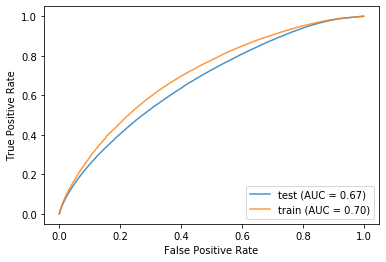

In [28]:
ax = plt.gca()
test_rf = plot_roc_curve(logreg, X_test_tf, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(logreg,X_train_tf, y_train,ax=ax, alpha=0.8, name="train")
plt.show()
#AUC curve for Logistic Regression

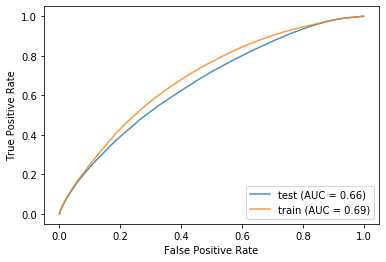

In [47]:
ax = plt.gca()
test_rf = plot_roc_curve(mnb, X_test_tf, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(mnb,X_train_tf, y_train,ax=ax, alpha=0.8, name="train")
plt.show()
#AUC curve for MultinomialNB

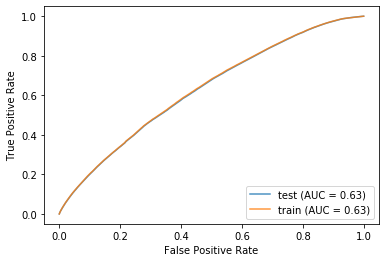

In [48]:
ax = plt.gca()
test_rf = plot_roc_curve(rfc, X_test_tf, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(rfc,X_train_tf, y_train,ax=ax, alpha=0.8, name="train")
plt.show()
#AUC curve for RandomForest Classifier

In [29]:
X_test_final = vc_tf_idf.transform(test["keywords"].apply(lambda x: np.str_(x)))

In [42]:
result=pd.DataFrame()
result["ID"]=test["ID"]
result["sex"]=logreg.predict(X_test_final)

In [ ]:
result["sex"]=result["sex"].replace(1, "M")
result["sex"]=result["sex"].replace(0, "F")

In [3]:
result.to_csv("test_result.csv",index=False,sep=',')

# Build model for "Age" and store results
Compare to 6 other regressors that we have tried with a small dataset with 50K of rows.   
SGD regressor has the best performance in test.   
6 other regressors are: Logistic Regression, Linear Regression, multinomialNB, Random Forest Regressor, Adabooster Regressor, and Gradientboosting Regressor.   
So for the whole dataset, we only apply SGD regressor to save time.

In [9]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=0.00001,max_iter=10000,random_state=42)
sgd.fit(X_train_tf,z_train)

SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [32]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
predictionage = dict()
predictionage["sgd"] = sgd.predict(X_test_tf)
print("Mean square error:%.4f"%(mean_squared_error(z_test,predictionage["sgd"])))
print("Mean absolute error:%.4f"%(mean_absolute_error(z_test,predictionage["sgd"])))
print("R square: ", '{:.2%}'.format(r2_score(z_test,predictionage["sgd"])))

Mean square error:154.2213
Mean absolute error:9.9452
R square:  10.63%


In [19]:
print(classification_report(np.floor((z_test+5)/10)*10,np.floor((predictionage["sgd"]+5)/10)*10))
# 10 stands for age group between 5-15, 20 stands for age group between 15-25 and so on

              precision    recall  f1-score   support

        10.0       0.00      0.00      0.00      2702
        20.0       0.00      0.00      0.00     67313
        30.0       0.33      0.01      0.01    180655
        40.0       0.36      0.55      0.44    375832
        50.0       0.26      0.56      0.36    320030
        60.0       0.31      0.04      0.07    223000
        70.0       0.26      0.00      0.00    100490
        80.0       0.00      0.00      0.00     12719
        90.0       0.00      0.00      0.00       902
       100.0       0.00      0.00      0.00        87

    accuracy                           0.31   1283730
   macro avg       0.15      0.12      0.09   1283730
weighted avg       0.29      0.31      0.23   1283730



In [27]:
predictionage["dif"]=predictionage["sgd"]-z_test
predictionage["dif"]=predictionage["dif"].map(lambda x: 0 if abs(x)>5 else 1)
print("1 stands for the precision rate of the whole test data")
print(predictionage["dif"].value_counts(1))

1 stands for the precision rate of the whole test data
0    0.691173
1    0.308827
Name: age, dtype: float64


In [55]:
result=pd.read_csv("test_result.csv")
result["age"]=sgd.predict(X_test_final)
result.to_csv("test_result.csv",index=False,sep=',')